In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import PIL

from mac0460_5832.utils import *
from mac0460_5832.WOperator import *
from mac0460_5832.WOperatorLearner import *

# MAC0460/5832 - Lista 1: Aprendizado de W-Operadores

### Data de Entrega: 23h55m do dia 05/05/2017


Q1. Encontre, utilizando a técnica de aprendizado de w-operadores vista em sala, o operador 1x3 (1 linha, 3 colunas) capaz de transformar a imagem src1 em dest1 (veja as variáveis abaixo) mostrando a tabela de padrões encontrada. Teste seu operador na imagem src1 e verifique que ele funciona como esperado. Teste seu operador nas imagens images/q1/1_test1.png e images/q1/1_test2.png desenhando as imagens obtidas (sugestão: use a função draw_img do arquivo mac0460_5832/utils.py).

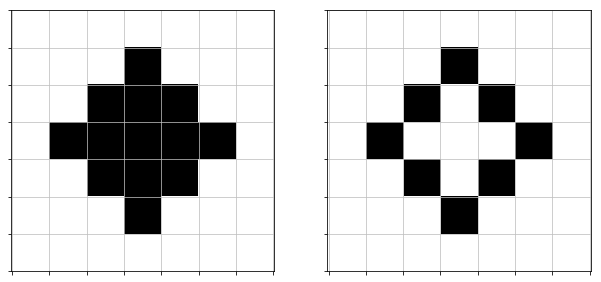

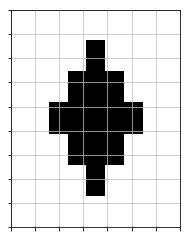

7 9
{'[[ 0.  0.  0.]]': [26, 0], '[[ 0.  0.  1.]]': [5, 0], '[[ 0.  1.  0.]]': [0, 2], '[[ 1.  0.  0.]]': [5, 0], '[[ 0.  1.  1.]]': [0, 3], '[[ 1.  1.  1.]]': [5, 0], '[[ 1.  1.  0.]]': [0, 3]}


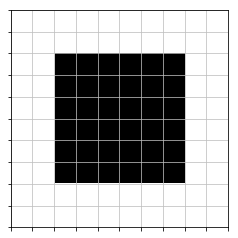

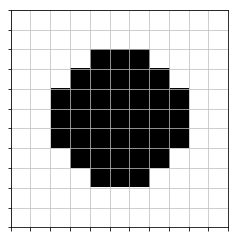

In [2]:
src1 = read_img('images/q1/1_src.png')
dest1 = read_img('images/q1/1_dest.png')
draw_img_pair(src1, dest1)

# creates w-operator and samples image
wopl = WOperatorLearner (1, 3)
wopl.sample_image (src1, dest1)

test1_1 = read_img('images/q1/1_test1.png')
test1_2 = read_img('images/q1/1_test2.png')
draw_img(test1_1)
draw_img(test1_2)

Q2. Aprenda o operador 3x3 para detecção de bordas. Treine seu operador nas imagens da pastas images/q2/ usando os pares (q2_src\*.png, q2_dest\*.png). Teste seu operador nas imagens images/q2/q2_test.png e images/q2/q2_test2.png. Algumas das imagens de treino são desenhadas abaixo.

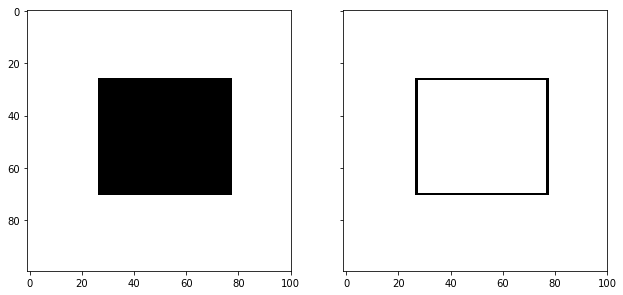

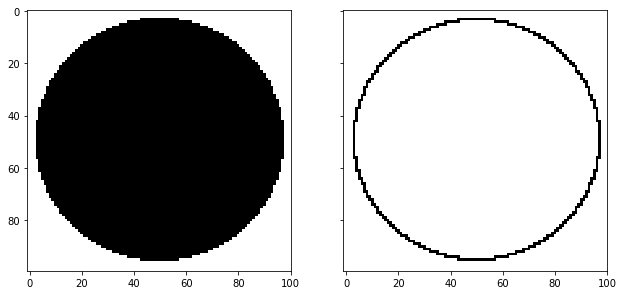

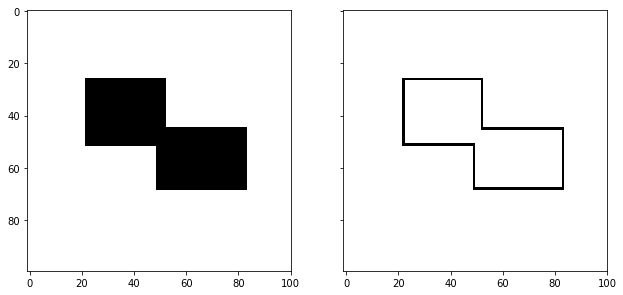

In [3]:
src2_1 = read_img('images/q2/q2_src1.png')
src2_2 = read_img('images/q2/q2_src2.png')
src2_3 = read_img('images/q2/q2_src3.png')

dest2_1 = read_img('images/q2/q2_dest1.png')
dest2_2 = read_img('images/q2/q2_dest2.png')
dest2_3 = read_img('images/q2/q2_dest3.png')


draw_img_pair(src2_1, dest2_1)
draw_img_pair(src2_2, dest2_2)
draw_img_pair(src2_3, dest2_3)

Q3. Use o algoritmo de aprendizado para obter um operador capaz de eliminar ruído. Use no treinamento as imagens images/q3/q3_src\*.png sempre com o mesmo target images/q3/q3_dest.png. Teste a janela com 5 elementos (cruz). Teste seu operador nas imagens images/q3/q3_test1.png e images/q3/q3_test2.png. Calcule e plote os erros $E_{in}$ e $E_{out}$ obtidos durante o treinamento.

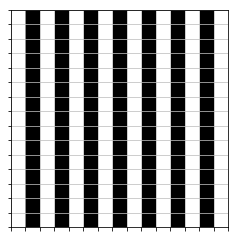

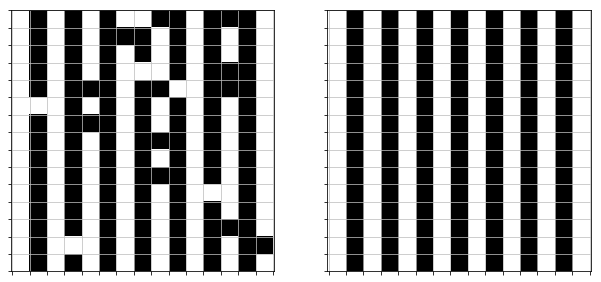

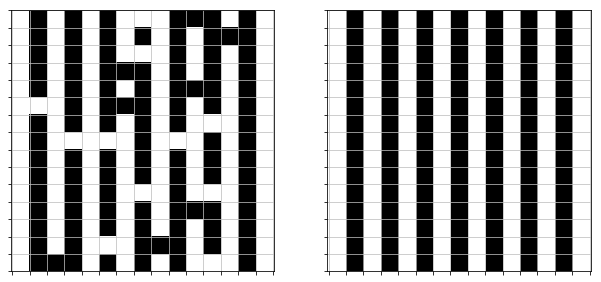

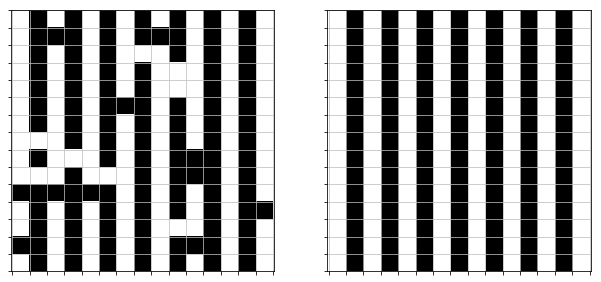

In [4]:
src3_1 = read_img('images/q3/q3_src1.png')
src3_2 = read_img('images/q3/q3_src2.png')
src3_3 = read_img('images/q3/q3_src3.png')
src3_4 = read_img('images/q3/q3_src4.png')
dest3 = read_img('images/q3/q3_dest.png')

draw_img(dest3)

draw_img_pair(src3_1, dest3)
draw_img_pair(src3_2, dest3)
draw_img_pair(src3_3, dest3)

Q4. Projete um operador para aprender a extrair a letra 's' de imagens de texto. Para isso utilize os pares de imagens q4_src\*.png q4_dest\*.png da pasta images/q4/train. Teste seu operador nas imagens da pasta images/q4/test. Utilize a composição de janelas pequenas. Avalie o erro do seu operador comparando a saída obtida por ele com a saída esperada (imagens q4_gt\*.png da pasta images/q4/test).

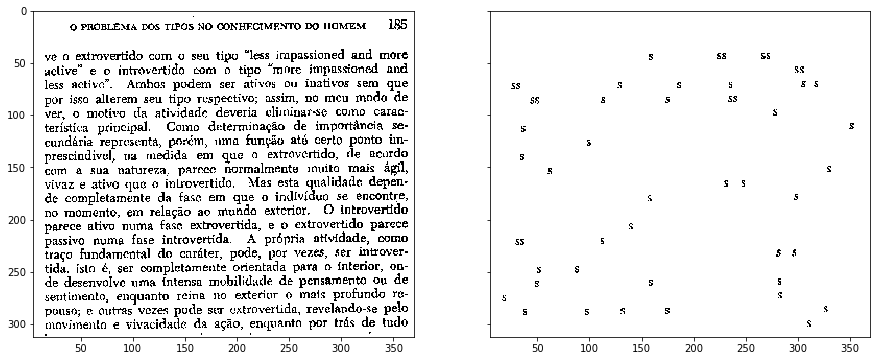

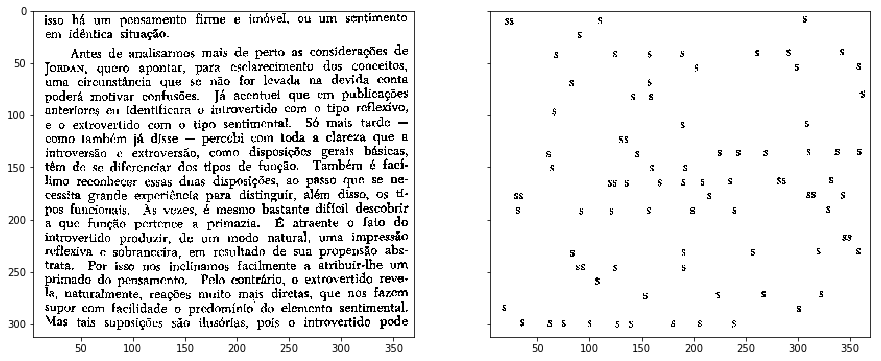

In [5]:
dest4_1a = read_img("images/q4/train/q4_dest1a.png")
src4_1a = read_img("images/q4/train/q4_src1a.png")
dest4_1b = read_img("images/q4/train/q4_dest1b.png")
src4_1b = read_img("images/q4/train/q4_src1b.png")
draw_img_pair(src4_1a, dest4_1a, figsz=(15, 6))
draw_img_pair(src4_1b, dest4_1b, figsz=(15, 6))

Q5. Utilizando a técnica de multiresolução, aprenda o operador capaz de remover ruído das imagens da pasta images/q5/. Utilize os pares de imagens (q5_src\*.png, q5_dest.png) para o treinamento e depois teste seu  operador nas imagens q5_test1.png e q5_test2.png.

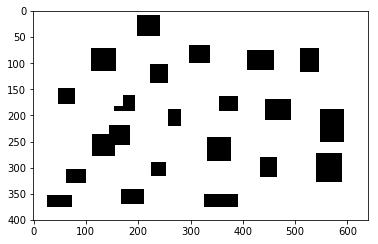

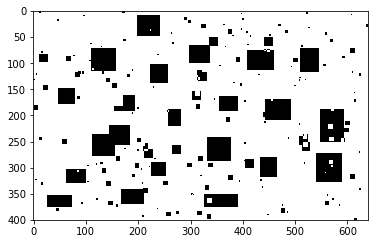

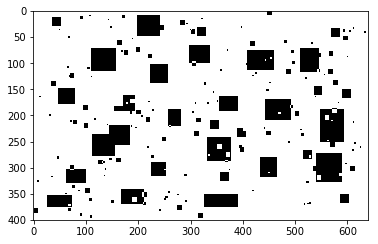

In [6]:
dest5 = read_img("images/q5/q5_dest.png")
src5_1 = read_img("images/q5/q5_src1.png")
src5_2 = read_img("images/q5/q5_src2.png")
draw_img(dest5)
draw_img(src5_1)
draw_img(src5_2)

Q6. Utilize a técnica de envelope, como visto em sala, para remover ruído de imagens. Use o mesmo dataset da questão anterior e as funções de morfologia disponíveis em mac0460_5832/utils.py para definir as funções $\alpha$ e $\beta$. Um exemplo de erosão em uma das imagens de treino é mostrado abaixo. Comente sobre a escolha das funções $\alpha$ e $\beta$.

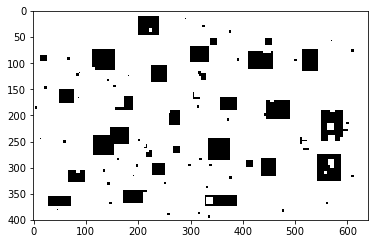

In [7]:
src6_1 = read_img("images/q5/q5_src1.png")
draw_img(erosion(src6_1, se_box(2)))

Q7. Utilize a técnica de envelope com multiresolução para aprender um operador capaz de remover ruído de imagens. Para cada uma das janelas, defina funções $\alpha$ e $\beta$ (podem ser diferentes). Compare o resultado obtido aplicando a mistura de técnicas com os resultados das duas questões anteriores.

Q8. A função gen_rand_imgs abaixo retorna um par de imagens. A primeira contém alguns pontos gerados aleatoriamente. A segunda é a dilatação da primeira por um elemento estruturante em forma de cruz. Aprenda o operador capaz de realizar essa transformação, gerando os pares de src e dest. Crie os dados de treinamento baseado na equação vista em sala ($m(\epsilon, \delta, H) = \frac{1}{\epsilon}ln\frac{|H|}{\delta}$). Compare o resultado obtido pelo seu classificador (gere mais pares para teste e ter uma estimativa de $E_{out}$) para $\epsilon = [0.2, 0.1]$ e $\delta = [0.3, 0.2]$.

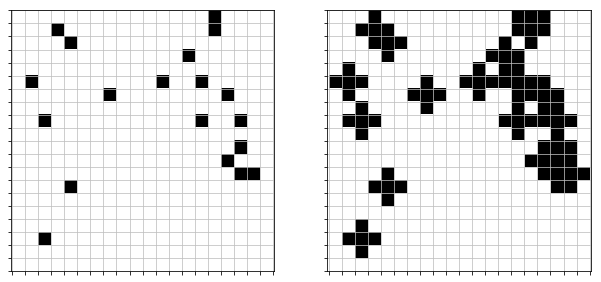

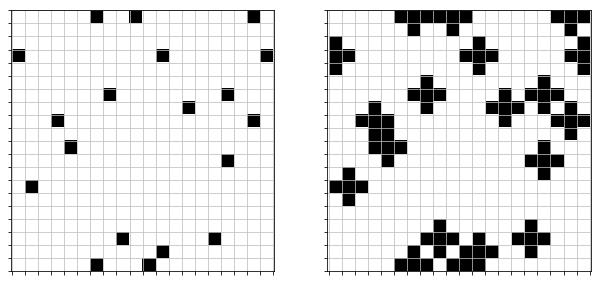

In [8]:
def gen_rand_imgs():
    noise = np.zeros((20, 20)).astype(bool)
    num_pixels = 20
    x = np.random.randint(0, 20, num_pixels)
    y = np.random.randint(0, 20, num_pixels)

    for i in range(num_pixels):
        noise[x[i], y[i]] = 1

    return noise, dilation(noise, se_cross(1))

src5_1, dest5_1 = gen_rand_imgs()
src5_2, dest5_2 = gen_rand_imgs()
draw_img_pair(src5_1, dest5_1)
draw_img_pair(src5_2, dest5_2)